In [1]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from utils.read_results_helpers import *
from utils.plotting_helpers import *

In [2]:
capital_costs = get_tech_costs('capital_cost')
capital_costs = capital_costs[capital_costs['component'].isin(['Store'])]

# Exclude beccs
capital_costs = capital_costs[~capital_costs['carrier'].str.contains('beccs')]

In [3]:
def plot_results(files_sorted, poi_results, color_dict, poi, sorted_technologies, outfile_suffix = ''):
    """
    Plot results, main plots are normalized cost and dispatch
    """
    tech_names, tech_costs, system_poi_values = [], [], []

    # Create figure
    fig, ax = plt.subplots()

    if 'dispatch' in poi:
        sorted_technologies['generators'].append('unutilized capacity')

    # Flatten sorted_technologies dictionary to list
    sorted_components = [item for sublist in sorted_technologies.values() for item in sublist]

    # Loop over all case pickle files in all_firm_case folder
    max_result = 0
    for i,case_file in enumerate(files_sorted):
        get_value = False

        results = poi_results[i]
        
        if i==0 or len([x for x in results.values() if x != 0]) > 0:
  
            # Stacked bar plot of results
            bottom_value = 0
            if case_file != files_sorted[-1]:
                x_tick_label = files_sorted[i+1].replace('all_firm', '').replace('.pickle', '').replace('_{0}_'.format(i), '')
                if x_tick_label == 'CO2_storage_tank' or 'load' in x_tick_label:
                    tech_name = x_tick_label.replace('_', ' ')
                else:
                    tech_name = x_tick_label
                if tech_name in capital_costs['carrier'].values:
                    if len(list(capital_costs[capital_costs['carrier'] == tech_name]['capital_cost'].values)) == 1:
                        tech_names.append(tech_name)
                        tech_costs.append(capital_costs[capital_costs['carrier'] == tech_name]['capital_cost'].values[0])
                    else:
                        tech_names.append(tech_name + '_charger')
                        tech_costs.append(capital_costs[capital_costs['carrier'] == tech_name]['capital_cost'].values[0])
                        tech_names.append(tech_name + '_discharger')
                        tech_costs.append(capital_costs[capital_costs['carrier'] == tech_name]['capital_cost'].values[1])
                    get_value = True
                if "CO2" in x_tick_label:
                    x_tick_label = "direct air capture"
            else:
                if "no_generators" in outfile_suffix:
                    x_tick_label = "no storage left"
                else:
                    x_tick_label = "only solar and wind"
            x_tick_label = x_tick_label.replace('_', ' ')
            if x_tick_label == 'beccs':
                x_tick_label = 'BECCS'

            for component in sorted_components:

                if "no_generators" in outfile_suffix and (component == 'CO2 storage tank' or component == 'direct air capture'):
                    continue
                if not case_file == 'all_firm_all.pickle':
                    if component not in results or results[component] == 0:
                        continue
                
                if 'dispatch' in poi and not component in sorted_technologies['generators']:
                    continue

                hatched, fill_color, hatch_color = get_hatching_color(component, sorted_technologies, color_dict)

                ax.bar(x_tick_label, results[component], width=0.25, color=fill_color, hatch=hatched,
                edgecolor=hatch_color, bottom=bottom_value, label=component)

                bottom_value += results[component]

            # Get max result to determine y-axis limits
            if sum(results.values()) > max_result:
                max_result = sum(results.values())

            if case_file != files_sorted[-1] and get_value == True:
                system_poi_values.append(sum(results.values()))
                if len(list(capital_costs[capital_costs['carrier'] == tech_name]['capital_cost'].values)) == 2:
                    system_poi_values.append(sum(results.values()))
            
            # Get legend handles and labels for all_firm_all case
            if case_file == 'all_firm_all.pickle':
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: sorted_components.index(t[0])))
                labels = [x.replace('_', ' ') for x in labels]
                labels = [x.replace('beccs', 'BECCS') for x in labels]
                labels = [x.replace('unutilized capacity', 'unutilized available generation') for x in labels]

    # Plot labels
    ax = set_x_y_labels(outfile_suffix, poi, ax)

    ax.set_ylim(0, 1.1*max_result)
  
    # Order the legend entries into the columns
    if "no_generators" in outfile_suffix:
        sorted_technologies['demand_handling'] = [x for x in sorted_technologies['demand_handling'] if x != 'CO2 storage tank' and x != 'direct air capture']
    
    # Legend
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0., -0.42, 1., 0.), ncol=3, fontsize=7)

    # x labels
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right', rotation_mode='anchor', fontsize=8)

    # Add dashed line at 1 for normalized dispatch
    if poi == 'normalized_dispatch':
        ax.axhline(y=1, color='black', linestyle=(0, (5, 5)), linewidth=0.4)
        # Add tick at 1 for normalized dispatch
        ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        

    # Save plot
    if not os.path.exists('figures'):
        os.makedirs('figures')

    # save jpeg with higher resolution
    plt.savefig('figures/total_{0}{1}.jpeg'.format(poi, outfile_suffix), dpi=400, bbox_inches='tight')
    plt.savefig('figures/total_{0}{1}.pdf'.format(poi, outfile_suffix), dpi=600, bbox_inches='tight')
    plt.show()

    return tech_names, tech_costs, system_poi_values

In [4]:
# Results directory
out_suff = '_most'
results_dir = 'output_data/all_firm_case' + out_suff + '/plotting/' 

# Technology categories
generators = ['onwind', 'solar-utility', 'natgas', 'natgas_wCCS', 'nuclear', 'beccs', 'hydro', 'geothermal']
storage_unconstrained = ['hydrogen_store', 'concrete_store', 'highT_molten_salt_store', 'liquid_air_store', 'lowT_molten_salt_store', 'pumped_heat_store', 'sand_store']
storage_constrained = ['lead_acid_store', 'lithium_ion_lfp_store', 'lithium_ion_nmc_store', 'ni_zn_store', 'redox_store', 'zn_air_store', 'zn_br_flow_store', 'zn_br_nonflow_store', 'compressed_air_store', 'gravity_brick_store', 'gravity_aboveground_store', 'gravity_underground_store', 'phs_store']
demand_handling = ['load shedding', 'load shifting backward', 'load shifting forward', 'CO2 storage tank', 'direct air capture']

technologies = {'generators': generators, 'storage_unconstrained': storage_unconstrained, 'storage_constrained': storage_constrained, 'demand_handling': demand_handling}

# Get color map
color_dict = get_colors()

In [5]:
# Get all case pickle files
files_sorted = get_files(results_dir)

# Parameters to plot
compute_pois = ['cost', 'capacity', 'normalized_cost', 'dispatch', 'normalized_dispatch']

# Get results to be plotted
results_dict = {}
for poi in compute_pois:
    # Normalized cost is computed by dividing total cost by total demand
    if poi == 'normalized_cost':
        use_results = results_dict['cost']
    elif poi == 'normalized_dispatch':
        use_results = results_dict['dispatch']
    else:
        use_results = []

    if 'dispatch' in poi:
        # Get firm generators
        firm_generators = [gen for gen in generators if gen not in ['solar-utility', 'wind-utility']]
    else:
        firm_generators = None

    results_dict[poi] = compute_results(results_dir, poi, files_sorted, firm_generators, pass_results=use_results)

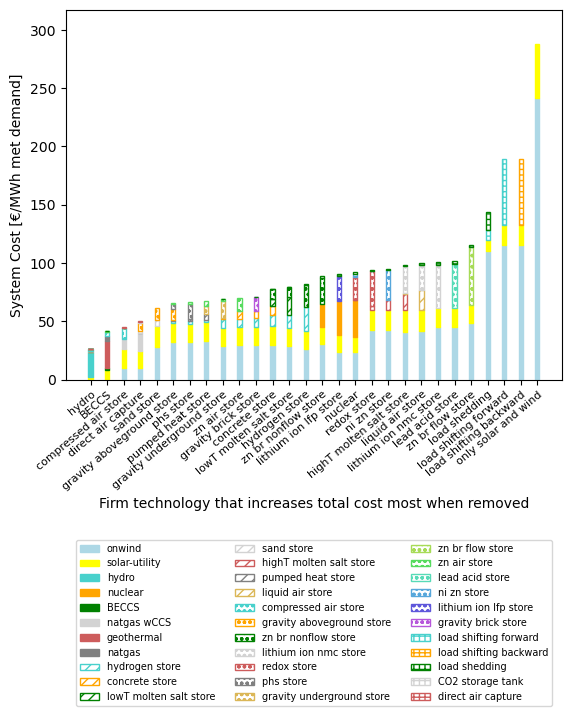

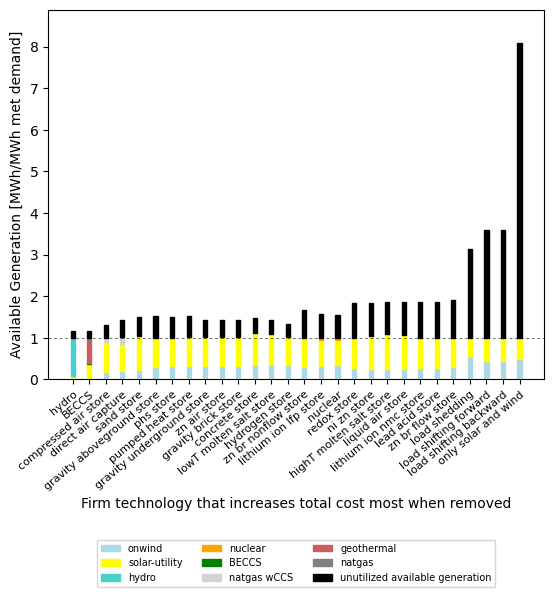

In [6]:
# Always order components the same way as they are ordered by mean normalized cost, except for wind and solar that come first

files_base = [f for f in os.listdir('output_data/all_firm_case_most/plotting') if f.endswith('.pickle')]
sorted_techs = calculate_mean_cost_comp_list(technologies, results_dict['normalized_cost'])

plot_pois = ['normalized_cost', 'normalized_dispatch']
poi_dict = {}
# Plot
for poi in plot_pois:
    technology_names, tech_costs, sys_poi_values = plot_results(files_sorted, results_dict[poi], color_dict, poi, sorted_techs, outfile_suffix=out_suff)
    poi_dict[poi] = {'tech_names': technology_names, 'tech_costs': tech_costs, 'sys_poi_values': sys_poi_values}

In [7]:
# Drop CO2 storage tank and load shifting
drop_storages = ['CO2 storage tank', 'load shifting backward', 'load shifting forward']
# Check if they are in the list
if any(storage in poi_dict['normalized_cost']['tech_names'] for storage in drop_storages):
    for drop_storage in drop_storages:
        storage_index = poi_dict['normalized_cost']['tech_names'].index(drop_storage)
        poi_dict['normalized_cost']['tech_names'].pop(storage_index)
        poi_dict['normalized_cost']['tech_costs'].pop(storage_index)
        poi_dict['normalized_cost']['sys_poi_values'].pop(storage_index)

In [8]:
marker_dict = {'compressed_air_store': 'o', 'sand_store': 'v', 'gravity_aboveground_store': '^', 'phs_store': '<', 'pumped_heat_store': '>', 'gravity_underground_store': '1', 'zn_air_store': '2', 'gravity_brick_store': '3', 'concrete_store': '4', 'lowT_molten_salt_store': 's', 'hydrogen_store': 'p', 'zn_br_nonflow_store': '*', 'lithium_ion_lfp_store': 'h', 'redox_store': 'H', 'ni_zn_store': '+', 'highT_molten_salt_store': 'x', 'liquid_air_store': 'D', 'lithium_ion_nmc_store': 'd', 'lead_acid_store': '|', 'zn_br_flow_store': '_'}

In [9]:
# Plot figure of tech_costs vs system_poi_values
def cost_plot(poi_dict, plotting_var):
    fig, ax = plt.subplots()

    # Plot tech costs if in comps
    colors = {'energy': 'black', 'power': 'blue', 'generator': 'black'}
    
    # Label with tech names
    for i, txt in enumerate(poi_dict['normalized_cost']['tech_names']):
        if txt == 'load shifting backward': continue
        txt_formatted = txt.replace('_', ' ').replace(' store', '').replace('forward','')
        # ax.annotate(txt_formatted, (poi_dict['normalized_cost']['tech_costs'][i]+300, poi_dict['normalized_cost']['sys_poi_values'][i]), 
                    # fontsize=10, rotation=20)
        tech = txt.replace('_discharger', '').replace('_charger', '')
        hatch, fill_color, hatch_color = get_hatching_color(tech, sorted_techs, color_dict)
        marker = marker_dict[tech]
        ax.scatter(poi_dict['normalized_cost']['tech_costs'][i], poi_dict['normalized_cost']['sys_poi_values'][i], 
               color=hatch_color, s=28, marker=marker)
    ax.set_xlabel('Amortized capital cost [€/MW{0}/year]'.format('h' if plotting_var == 'energy' else ''))
    ax.set_ylabel('System cost [€/MWh met demand]')
    ax.set_title('{0} capital cost'.format(plotting_var.capitalize()))
    ax.set_ylim(0.,120.)
    plt.savefig('figures/cost_vs_sys_cost_{0}.pdf'.format(plotting_var), dpi=500, bbox_inches='tight')
    plt.savefig('figures/cost_vs_sys_cost_{0}.png'.format(plotting_var), dpi=500, bbox_inches='tight')

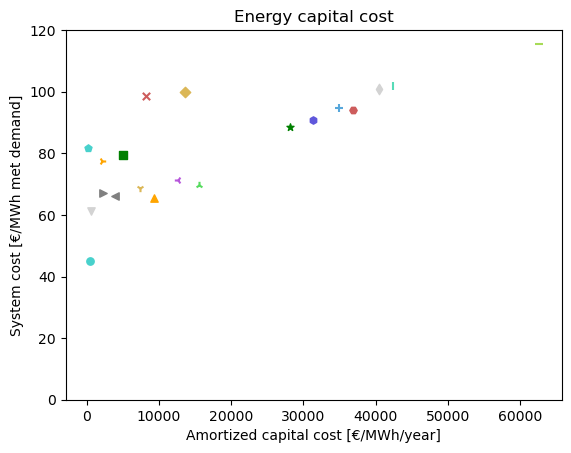

In [10]:
# Plot cost vs system cost
cost_plot(poi_dict, 'energy')